In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy as scp
from scipy import optimize
from dataManager import dataManager
from itertools import product
import os
import seaborn as sns
import xarray
myData = dataManager("resetting","simplePotentials1")

def pade4_2(x,A,U1,D1,U2,D2,D3,D4):
    return (U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def pade5_3(x,A,U1,D1,U2,D2,U3,D3,D4,D5):
    return (U3*x**3+U2*x**2+x*U1+A)/(D5*x**5+D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def pade6_4(x,A,U1,D1,U2,D2,U3,D3,U4,D4,D5,D6):
    return (U4*x**4+U3*x**3+U2*x**2+x*U1+A)/(D6*x**6+D5*x**5+D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def moonWalkPrediction(func,values,rate,stepSize,forwardStep=1e-6,forwardN=100):
    zs = np.linspace(0,forwardStep,forwardN)
    mus = []
    for z in zs:
        Tr = sum(np.exp(-z*values))/len(values)
        mus.append((1-Tr)/(z*Tr))
    mus[0] = np.mean(values)
    for i in range(int(rate/stepSize)):
        zs = zs + stepSize
        Trs = 1/(mus*zs+1)
        zs = np.insert(zs,0,0)
        Trs = np.insert(Trs,0,1)
        try:
            fit = scp.optimize.curve_fit(func, zs, Trs,bounds=(0,np.inf))
            mus.insert(0,(fit[0][2]-fit[0][1])/fit[0][0])
        except:
            mus.insert(0,mus[0])

    zs = zs + rate - stepSize*int(rate/stepSize)
    Trs = 1/(mus*zs+1)
    zs = np.insert(zs,0,0)
    Trs = np.insert(Trs,0,1)
    try:
        fit = scp.optimize.curve_fit(func, zs, Trs,bounds=(0,np.inf))
        mus.insert(0,(fit[0][2]-fit[0][1])/fit[0][0])
    except:
        mus.insert(0,mus[0]) 
    return zs, mus


In [170]:
myData.updateDirectoryFPT("results")
# myData.updateDirectoryPositions("resultsNoStop")

In [178]:
datalist = []
params = dict(thermostat="Langevin",dataType="FPT",potential="custom1",restartRate=0,width=9,height=0.000125)
# params = dict(thermostat="Langevin",dataType="FPT",dimensions=2,restartRate=0)

for doc in myData.collection.find(params):
    fpts = np.loadtxt(doc["path"],skiprows=1)
    # try:
    datalist.append(pd.DataFrame(dict(seed=doc["fileSeed"],rate=doc["restartRate"],tails=doc["tails"],height=doc["height"],width=doc["width"],
                                  start = [doc["start"]], N = doc["N"], mean = round(fpts.mean()),gamma=doc["gamma"],
                                  std = round(fpts.std()), CV = fpts.std()/fpts.mean(),min = fpts.min(), max = fpts.max())))
    # newData = pd.DataFrame(dict(seed=doc["fileSeed"],rate=doc["restartRate"],amplitude=doc["amplitude"],stretchx=doc["stretchx"],stretchy=doc["stretchy"],
    #                           start = [doc["startx"]], N = doc["N"], mean = round(fpts.mean()),gamma=doc["gamma"],
    #                           std = round(fpts.std()), CV = fpts.std()/fpts.mean(),min = fpts.min(), max = fpts.max()))
    # if "slopex" in doc.keys():
    #     newData["slopex"] = doc["slopex"]
    # datalist.append(newData)
    # except:
    #     myData.collection.update_one({"fileSeed": doc["fileSeed"]}, {"$set": {"slopex": 1}})
data = pd.concat(datalist)
data.sort_values("CV")

,seed,rate,tails,height,width,start,N,mean,gamma,std,CV,min,max
0,7684919787622083,0.0,1.000000e-09,0.000125,9.0,250.0,460,1767290,0.01,2022929,1.144651,70395.0,12824456.0
0,6069496007290953,0.0,1.000000e-09,0.000125,9.0,175.0,550,1370033,0.01,2089663,1.525265,30539.0,14307485.0
0,6561584712707453,0.0,1.000000e-09,0.000125,9.0,100.0,810,952237,0.01,1863402,1.956867,7766.0,16870953.0
0,5678400117337106,0.0,1.000000e-09,0.000125,9.0,25.0,2830,279300,0.01,897331,3.212787,653.0,13564451.0


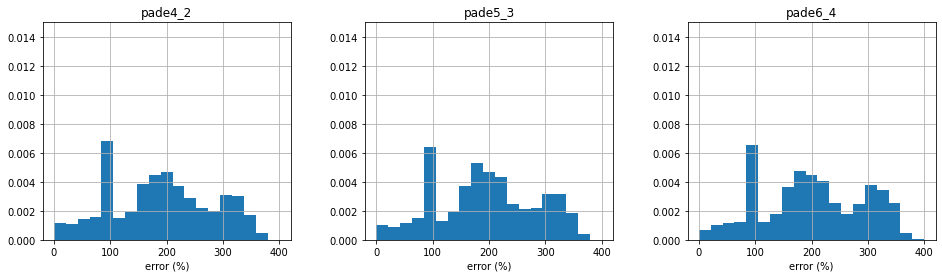

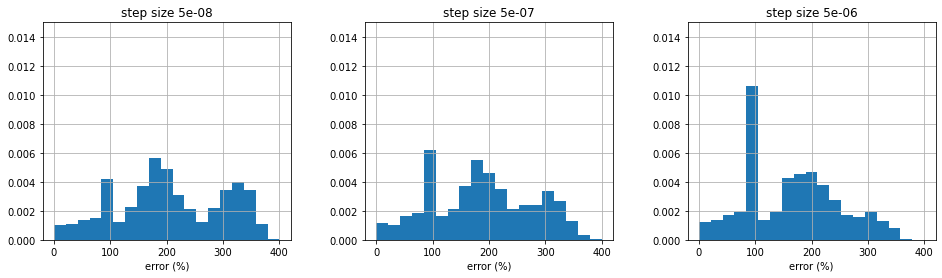

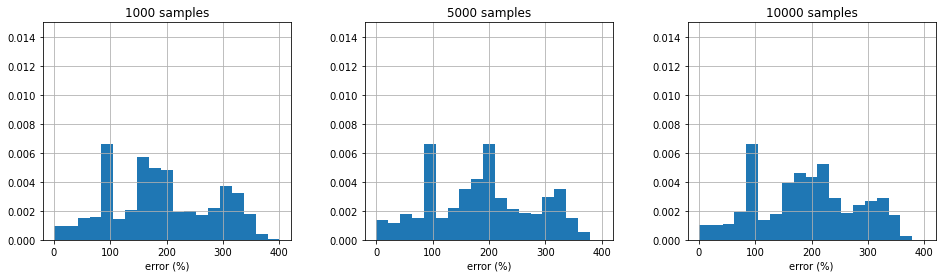

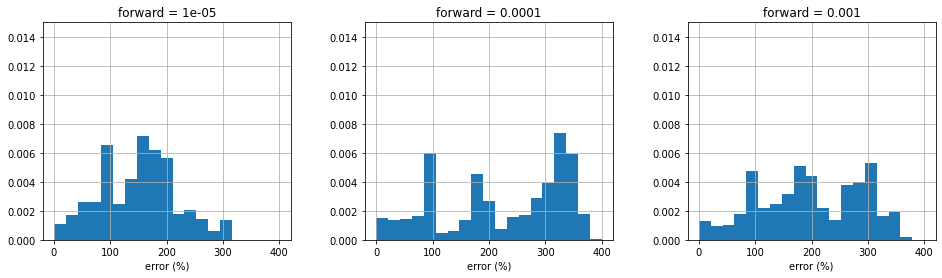

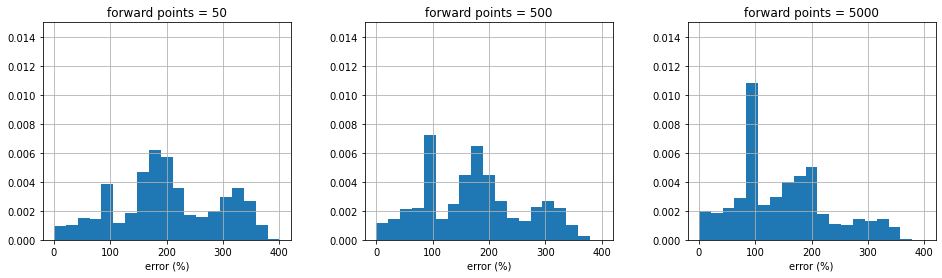

In [218]:
datalist = []
Nfpts = [1000,5000,10000]
forwardStep = [1e-5,1e-4,1e-3]
forwardN = [50,500,5000]
stepSize = [5e-8,5e-7,5e-6]
for doc in myData.collection.find({"dataType":"predictions"}):
    searchDoc = {"dataType":"FPT","restartRate":0}
    for key in doc.keys():
        if key not in ["_id","path","fileSeed","restartRate","dataType"]:
            searchDoc[key] = doc[key]
    newData = pd.read_csv(doc["path"])
    realMean = np.loadtxt(myData.collection.find_one(searchDoc)["path"],skiprows=1).mean()
    newData["error"] = abs(realMean-newData["prediction"])/newData["prediction"]*100
    newData["rate"] = doc["restartRate"]
    newData["dimensions"] = doc["dimensions"]
    newData = newData.drop(columns="Unnamed: 0")
    datalist.append(newData)
data = pd.concat(datalist).reset_index(drop=True)
fig, axs = plt.subplots(1,3,figsize=(16,4))
funcs = list(data.func.drop_duplicates())
for i in range(3):
    data.loc[data.func==funcs[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(funcs[i])
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)

fig, axs = plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    data.loc[data.stepSize==stepSize[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(f"step size {stepSize[i]}")
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)

fig, axs = plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    data.loc[data.Nfpts==Nfpts[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(f"{Nfpts[i]} samples")
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)
    
fig, axs = plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    data.loc[data.forwardStep==forwardStep[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(f"forward = {forwardStep[i]}")
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)
    
fig, axs = plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    data.loc[data.forwardN==forwardN[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(f"forward points = {forwardN[i]}")
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)

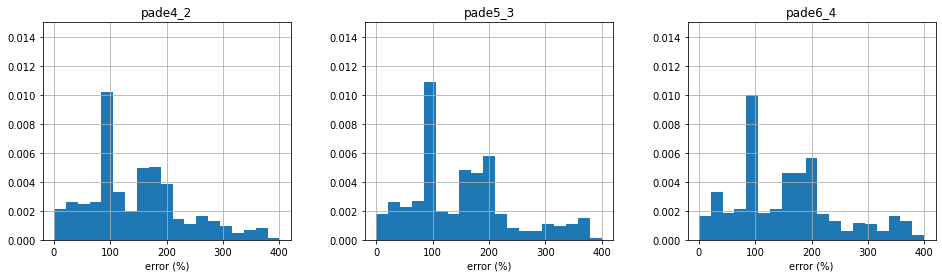

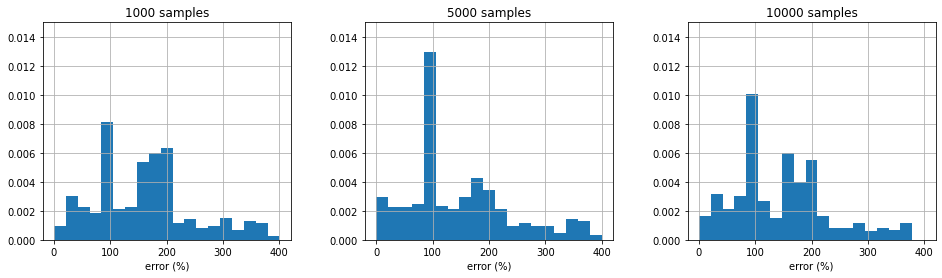

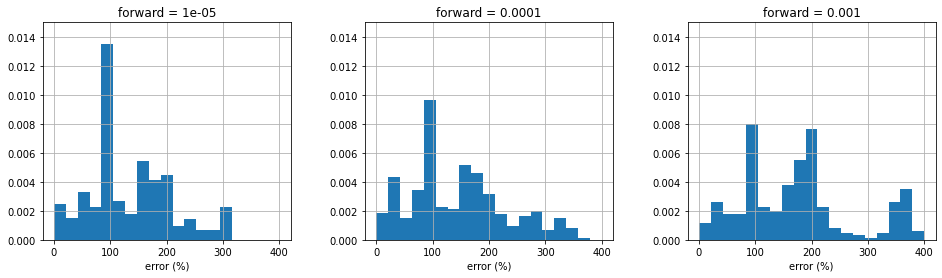

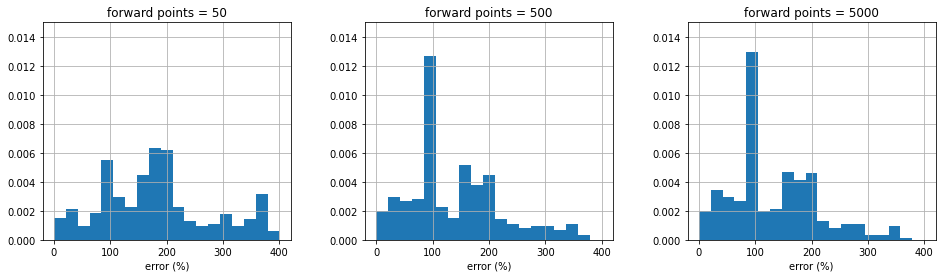

In [219]:
datalist = []
for doc in myData.collection.find({"dataType":"predictionsNoWalk"}):
    searchDoc = {"dataType":"FPT","restartRate":0}
    for key in doc.keys():
        if key not in ["_id","path","fileSeed","restartRate","dataType"]:
            searchDoc[key] = doc[key]
    newData = pd.read_csv(doc["path"])
    realMean = np.loadtxt(myData.collection.find_one(searchDoc)["path"],skiprows=1).mean()
    newData["error"] = abs(realMean-newData["prediction"])/newData["prediction"]*100
    newData["rate"] = doc["restartRate"]
    newData["dimensions"] = doc["dimensions"]
    newData = newData.drop(columns="Unnamed: 0")
    datalist.append(newData)
data = pd.concat(datalist).reset_index(drop=True)
bins = np.linspace(0,400,20)
fig, axs = plt.subplots(1,3,figsize=(16,4))
funcs = list(data.func.drop_duplicates())
for i in range(3):
    data.loc[data.func==funcs[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(funcs[i])
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)
    
fig, axs = plt.subplots(1,3,figsize=(16,4))
Nfpts = list(data.Nfpts.drop_duplicates())
for i in range(3):
    data.loc[data.Nfpts==Nfpts[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(f"{Nfpts[i]} samples")
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)
    
fig, axs = plt.subplots(1,3,figsize=(16,4))
forwardStep = list(data.forwardStep.drop_duplicates())
for i in range(3):
    data.loc[data.forwardStep==forwardStep[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(f"forward = {forwardStep[i]}")
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)
    
fig, axs = plt.subplots(1,3,figsize=(16,4))
forwardN = list(data.forwardN.drop_duplicates())
for i in range(3):
    data.loc[data.forwardN==forwardN[i]].loc[data.error<1000000000000].hist("error",density=True,ax=axs[i],bins=bins)
    axs[i].set_title(f"forward points = {forwardN[i]}")
    axs[i].set_xlabel("error (%)")
    axs[i].set_ylim(0,0.015)

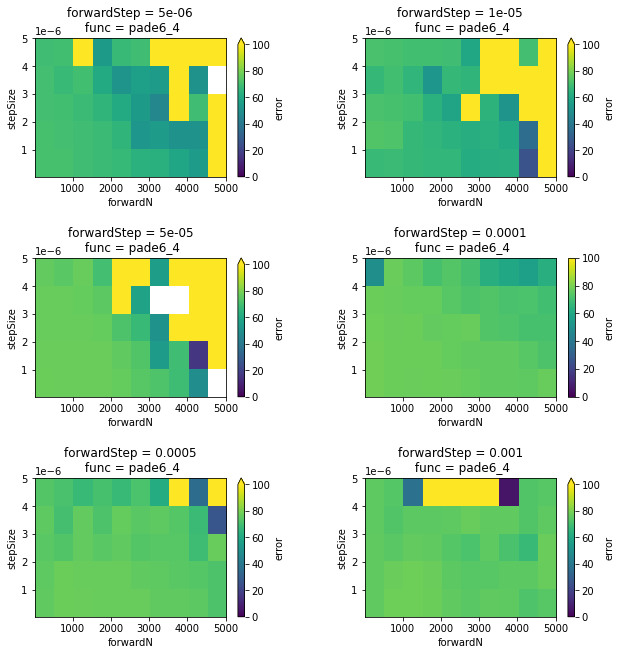

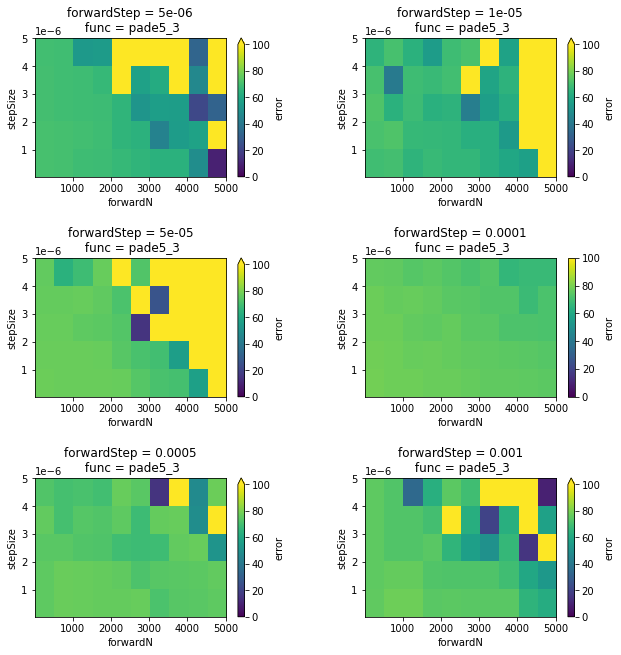

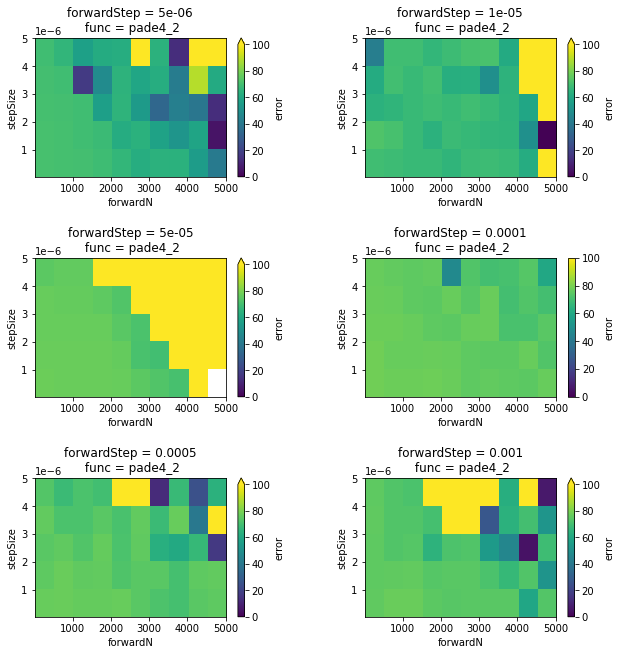

In [129]:
data = pd.read_csv(myData.collection.find_one({"dataType":"predictions"})["path"])
data["error"] = abs(600000-data.prediction)/6000
steps = [5e-6,1e-5,5e-5,1e-4,5e-4,1e-3]
for func in ["pade6_4","pade5_3","pade4_2"]:
    fig,axs = plt.subplots(3,2,figsize=(10,10))
    fig.tight_layout(pad=6.0)
    axs = axs.flatten()
    for i in range(6):
        forPlot = data.loc[data.Nfpts==1000].loc[data.func==func].loc[data.forwardStep==steps[i]].set_index(["stepSize","forwardN"]).to_xarray()
        xarray.plot.imshow(forPlot["error"],ax=axs[i],vmin=0,vmax=100)
        axs[i].set_title(f"forwardStep = {steps[i]}\n func = {func}")

In [135]:
data = pd.read_csv(myData.collection.find_one({"dataType":"predictions"})["path"])
data["error"] = abs(600000-data.prediction)/6000
data.sort_values("error").loc[data.error<10]


,Unnamed: 0,Nfpts,stepSize,forwardStep,forwardN,func,prediction,error
3130,3130,5000,5.000000e-06,0.001000,100,pade5_3,601814.112101,0.302352
1672,1672,2500,5.000000e-07,0.001000,1000,pade5_3,597227.638334,0.462060
297,297,1000,1.000000e-07,0.000010,5000,pade4_2,595494.185265,0.750969
1929,1929,2500,5.000000e-06,0.000005,100,pade4_2,607762.272896,1.293712
3062,3062,5000,5.000000e-06,0.000100,10,pade6_4,609713.940007,1.618990
4191,4191,7500,5.000000e-06,0.001000,1000,pade4_2,615440.560051,2.573427
2908,2908,5000,1.000000e-06,0.000500,5000,pade5_3,621563.710742,3.593952
624,624,1000,5.000000e-07,0.001000,2500,pade4_2,570773.197317,4.871134
267,267,1000,1.000000e-07,0.000005,5000,pade4_2,631620.515323,5.270086
1546,1546,2500,5.000000e-07,0.000010,500,pade5_3,568336.231254,5.277295


In [ ]:
for doc in list(myData.collection.find({"N":10000})):
    if doc["restartRate"]!=0:
        newDocParams = {}
        for key in doc.keys():
            if key not in ["_id","path","N","dataType"]:
                newDocParams[key] = doc[key]
        print(newDocParams)
        fpts = np.loadtxt(doc["path"],skiprows=1)
        datalist = []
        Nfptss = [1000,2500,5000,7500,10000]
        forwardSteps = [1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3]
        forwardNs = [10,25,50,100,250,500,750,1000,2500,5000]
        stepSizes = [5e-8,1e-7,5e-7,1e-6,5e-6]
        count = 10
        for Nfpts, stepSize, forwardStep, forwardN in product(Nfptss,stepSizes,forwardSteps,forwardNs):
            count += 1
            if count%10==0:
                print(Nfpts,stepSize, forwardStep, forwardN)
            for func, funcname in zip([pade4_2,pade5_3,pade6_4],["pade4_2","pade5_3","pade6_4"]): 
                zs, mus = moonWalkPrediction(func=func,values=fpts[:Nfpts],rate=doc["restartRate"],stepSize=stepSize,forwardStep=forwardStep,forwardN=forwardN)
                newD = pd.DataFrame(dict(Nfpts=Nfpts,stepSize=[stepSize],forwardStep=forwardStep,forwardN=forwardN,func=funcname,prediction=mus[0]))
                datalist.append(newD)
        data = pd.concat(datalist,ignore_index=True)
        data.sort_values("prediction")
        filenumber = str(np.random.uniform()).split(".")[1]
        data.to_csv(f"predictions/pr{filenumber}")
        fileDict = dict(path=os.path.abspath(f"predictions/pr{filenumber}"),dataType="predictions",**newDocParams)
        myData.collection.insert_one(fileDict)
    # doc

{'fileSeed': '46717817747070256', 'restartRate': 1.5e-05, 'gamma': 0.01, 'tails': 1e-09, 'height': 0.00025, 'width': 25.0, 'simSeed': 1, 'thermostat': 'Langevin', 'start': 50.0, 'mass': 1, 'potential': 'custom1', 'project': 'resetting', 'dimensions': 1}


/tmp/ipykernel_1184937/1794425126.py:27: RuntimeWarning: invalid value encountered in double_scalars
  mus.append((1-Tr)/(z*Tr))
/home/ofirblumer/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1000 5e-08 1e-06 5000


In [40]:
# filenumber = str(np.random.uniform()).split(".")[1]
# data.to_csv(f"predictions/pr{filenumber}")
# fileDict = dict(path=os.path.abspath(f"predictions/pr{filenumber}"),dataType="predictions",**newDocParams)
# myData.collection.insert_one(fileDict)
realMean = 593575
data = pd.read_csv(myData.collection.find(dict(dataType="predictions",restartRate=1e-5))[0]["path"])
data["error"]= abs(data["prediction"]-realMean)/realMean*100
selectedData = data.loc[data.prediction<1e7].loc[data.prediction>0].sort_values("error").reset_index()
selectedData[:20]

,index,Unnamed: 0,Nfpts,stepSize,forwardStep,forwardN,func,prediction,error
0,79,0,1000,1.000000e-07,0.000010,5000,pade4_2,602131.299313,1.441486
1,934,0,10000,5.000000e-07,0.000050,250,pade4_2,603489.528913,1.670308
2,482,0,5000,1.000000e-07,0.000050,50,pade4_2,609644.977768,2.707321
3,69,0,1000,1.000000e-07,0.000005,5000,pade4_2,573966.238862,3.303502
4,282,0,2500,1.000000e-07,0.000050,50,pade4_2,615269.396029,3.654870
5,725,0,7500,5.000000e-07,0.000010,500,pade4_2,566554.149897,4.552222
6,32,0,1000,5.000000e-08,0.000050,50,pade4_2,634926.571908,6.966529
7,128,0,1000,5.000000e-07,0.000010,2500,pade4_2,551312.226332,7.120039
8,532,0,5000,5.000000e-07,0.000050,50,pade4_2,636629.371698,7.253400
9,379,0,2500,1.000000e-06,0.000010,5000,pade4_2,637516.551727,7.402864


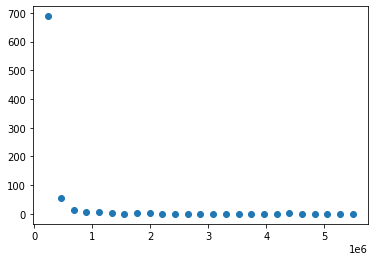

In [35]:
histo, bins = np.histogram(selectedData.prediction,bins=25)
plt.plot(0.5*(bins[1:]+bins[:-1]),histo,"o")

In [47]:
data2 = pd.read_csv(myData.collection.find(dict(dataType="predictions"))[0]["path"])
data2 = data2.drop(columns="Unnamed: 0")
allData = pd.concat([data,data2]).reset_index(drop=True)
allData.sort_values("prediction")
# filenumber = str(np.random.uniform()).split(".")[1]
allData.to_csv("predictions/pr5865694422841167")

In [36]:
# fileDict = dict(path=os.path.abspath("predictions/pr5865694422841167"),dataType="predictions",**newDocParams)
# myData.collection.insert_one(fileDict)
data = pd.read_csv(myData.collection.find(dict(dataType="predictions"))[0]["path"])
data = data.drop(columns="Unnamed: 0")
# data.to_csv("pr5865694422841167")

In [40]:
# first = np.array(data.loc[data.stepSize==1e-6].prediction)
# second = np.array(data.loc[data.stepSize==1e-7].prediction)
# third = np.array(data.loc[data.stepSize==1e-8].prediction)
# first = np.array(data.loc[data.forwardStep==1e-7].prediction)
# second = np.array(data.loc[data.forwardStep==1e-6].prediction)
# third = np.array(data.loc[data.forwardStep==1e-5].prediction)
# first = np.array(data.loc[data.forwardN==10].prediction)
# second = np.array(data.loc[data.forwardN==50].prediction)
# third = np.array(data.loc[data.forwardN==100].prediction)
# plt.plot(second/first,"o")
# plt.plot(third/first,"o")
# data.sort_values("prediction").reset_index()[-20:]
data.sort_values("prediction").reset_index()[:20]

,index,Nfpts,stepSize,forwardStep,forwardN,func,prediction
0,108,10000,1.000000e-08,1.000000e-07,10,pade4_2,82128
1,54,5000,1.000000e-08,1.000000e-07,10,pade4_2,82738
2,109,10000,1.000000e-08,1.000000e-07,10,pade6_4,88408
3,0,2500,1.000000e-08,1.000000e-07,10,pade4_2,89698
4,55,5000,1.000000e-08,1.000000e-07,10,pade6_4,92530
5,1,2500,1.000000e-08,1.000000e-07,10,pade6_4,92740
6,93,5000,1.000000e-06,1.000000e-07,50,pade6_4,101194
7,95,5000,1.000000e-06,1.000000e-07,100,pade6_4,101373
8,91,5000,1.000000e-06,1.000000e-07,10,pade6_4,104479
9,90,5000,1.000000e-06,1.000000e-07,10,pade4_2,104518


/tmp/ipykernel_1148103/784882252.py:6: RuntimeWarning: divide by zero encountered in log
  fes = -0.00025*np.log(hist)


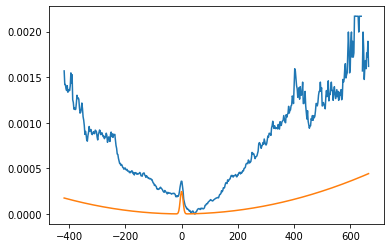

In [13]:
params = dict(dimensions=1,thermostat="Langevin",restartRate=5e-6,dataType="positions")
doc = myData.collection.find(params)[0]
positions = np.loadtxt(doc["path"],skiprows=1)
hist, xs = np.histogram(positions,bins=500)
xs = 0.5*(xs[1:] + xs[:-1])
fes = -0.00025*np.log(hist)
plt.plot(xs, fes-fes.min())
plt.plot(xs,1e-9*xs**2 + 0.00025*np.exp(-xs**2/50))

8946581740189135 10000
623973406320006 10000
7792212842003948 2510
2768292809707734 10000
946926356782233 1910
7627936264120772 1890


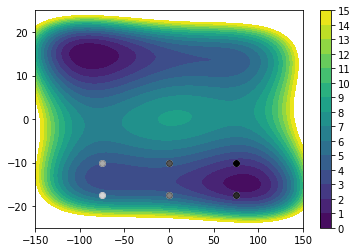

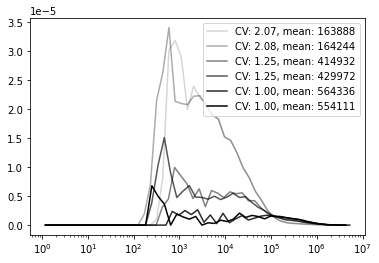

In [60]:
xs = [-150.00000001 + i/2 for i in range(601)]
ys = [-25.000000001 + i/10 for i in range(501)]
kbT = 0.00030
Cxy = 1
Cx = 4
Cy = 1
levels=[i for i in range(16)]
# levels=[i for i in range(16)]
datalist = []

for xtag in xs:
    x = xtag/75
    newRow = []
    for ytag in ys:
        y = ytag/10
        newRow.append(kbT*(x**4+y**4-2*x**2-4*y**2+x*y+0.3*x+0.1*y))
    datalist.append(pd.DataFrame({"x":xtag,"y":ys,"V":newRow}))
surface = pd.concat(datalist).reset_index()
surface.V -= surface.V.min() 
plt.tricontourf(surface.x,surface.y,surface.V/0.00025,levels=levels)
cbar = plt.colorbar(ticks=levels)
for alpha,points in zip(np.linspace(0.16,1,6), [(-75,-17.5),(-75,-10),(0,-17.5),(0,-10),(75,-17.5),(75,-10)]):
    plt.scatter(*points,c="white")
    plt.scatter(*points,c="black",alpha=alpha)
plt.figure()
params = dict(simType="WolfeQuapp")
for alpha,points in zip(np.linspace(0.16,1,6), [(-75,-17.5),(-75,-10),(0,-17.5),(0,-10),(75,-17.5),(75,-10)]):
    params["startx"] = points[0]
    params["starty"] = points[1]
    fpts = np.loadtxt(f"WolfeQuappResults//firstPassageTimes{myData.collection.find(params)[0]['fileSeed']}")
    print(myData.collection.find(params)[0]['fileSeed'],len(fpts))
    logbins = np.logspace(0,np.log10(max(fpts)),50)
    xs = 0.5*(logbins[1:] + logbins[:-1])
    vals,b = np.histogram(fpts,density=True,bins=logbins)
    plt.plot(xs,vals,label=f"CV: {format(fpts.std()/fpts.mean(),'.2f')}, mean: {int(fpts.mean())}",c="black",alpha=alpha)
plt.legend()
plt.xscale("log")

OSError: 1Dresults/1_s_25_0_g_0_01_t_5e-09_h_0_00025_w_100_0_r_100000000_m_Poisson_th_Langevin.csv not found.

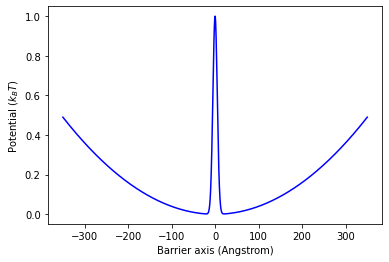

<Figure size 432x288 with 0 Axes>

In [36]:
xs = np.linspace(-350,350,2000)
tails = 1e-9
h = 0.00025
w = 25
potential = (tails*(abs(xs)**2)+h*np.exp(-0.5*xs**2/w))
plt.plot(xs,potential/0.00025,c="blue")
plt.xlabel("Barrier axis (Angstrom)")
plt.ylabel(r"Potential ($k_BT$)")
# for alpha,start in zip(np.linspace(0.16,1,6), [25,75,125,175,225,275]):
#     plt.scatter(start,1,c="black",alpha=alpha)

plt.figure()

for alpha,start,seed in zip(np.linspace(0.16,1,6), [25,75,125,175,225,275],[1,10001,20002,30003,40004,50005]):

    fpts = np.loadtxt(f"1Dresults/{seed}_s_{start}_0_g_0_01_t_5e-09_h_0_00025_w_100_0_r_100000000_m_Poisson_th_Langevin.csv")
    logbins = np.logspace(0,np.log10(max(fpts)),50)
    xs = 0.5*(logbins[1:] + logbins[:-1])
    vals,b = np.histogram(fpts,density=True,bins=logbins)
    plt.plot(xs,vals,label=f"CV: {format(fpts.std()/fpts.mean(),'.2f')}, mean: {int(fpts.mean())},N: {len(fpts)}",c="black",alpha=alpha)
plt.legend()
plt.xscale("log")